### Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

#### Restaurant_id — идентификационный номер ресторана / сети ресторанов;
#### City — город, в котором находится ресторан;
#### Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
#### Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
#### Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
#### Price Range — диапазон цен в ресторане;
#### Number of Reviews — количество отзывов о ресторане;
#### Reviews — данные о последних двух отзывах, которые отображаются на сайте ресторана;
#### URL_TA — URL страницы ресторана на TripAdvosor;
#### ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import europe_countries_info  # Файл из GitHub с данными по городам и странам Европы (доработан)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Специальный инструмент для разбивки
from sklearn.model_selection import train_test_split

# Необходимые библиотеки для модели
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [3]:
# Функция вычисления и установки среднего значения городского рейтинга (для признака "ranking")
def change_ranking(id):
    df_temp = df[df.id_ta == id]
    rank_mean = round(df_temp.ranking.mean()) # Вычисляем среднее значение городского рейтинга для пары
    
    for i in df_temp.index:
        df.at[i, 'ranking'] = rank_mean # Заменяем значение городского рейтинга

        
# Функция перевода стилей кухни из строковой переменной в список (для признака "cuisine_style")
def cuisine_to_list(item):
    if ',' in item: # Стилей кухни больше одной
        return item[2:-2].split("', '") # Выделяем стили кухни, разделенных запятой
    
    else: # Кухня одна
        aa = []
        aa.append(item[2:-2])
        
        return aa

In [4]:
# Функция извлечения дат из отзывов (исп. для признака "reviews")
# Возвращает дату последнего отзыва или nan, если отзывов нет 

def last_date_review(line):
    if len(line) < 10: return np.nan  # Если отзывов нет, возвращаем nan
    
    else:
        i = line.rfind("['")  # Находим начало записи дат
        dat_cont = line[i+2:-3]  # Выделяем контейнер с датами
        
        if ',' in dat_cont:  # Дат больше одной
            str_date = []
            str_date = dat_cont.split("', '")  # Выделяем даты, разделенные запятой
            list_date = pd.to_datetime(str_date, format='%m/%d/%Y')  # Преобразуем выделенные данные в формат datetime
            
            # Выделяем и возвращаем дату последнего отзыва
            if list_date[0] > list_date[1]:
                return list_date[0]
            
            return list_date[1]
        
        else: # Дата одна
            return pd.to_datetime(dat_cont, format='%m/%d/%Y')

In [5]:
# Функция определения государства по названию города
def find_country(item):
    i = 0
    for city in df_cities['cities']:
        if item in city: 
            return df_cities.iloc[i]['country']
        i += 1

        
# Функция определения региона по названию города
def find_region(item):
    i = 0
    for city in df_cities['cities']:
        if item in city: 
            return df_cities.iloc[i]['region']
        i += 1

In [6]:
# Функция очиски количественных признаков от выбросов
def clear_sign_num(sign):
    sign_dscrb = df[sign].describe()
    delta = (sign_dscrb[6] - sign_dscrb[4])*1.5 # Рассчитываем межквартильный порог
    top_board = sign_dscrb[6] + delta # Верхняя граница выбросов
    bot_board = sign_dscrb[4] - delta # Нижняя граница выбросов
        
    # Очищаем по нижней границе
    df.drop(df[(df[sign] < bot_board)].index, axis= 0, inplace= True) 
    
    # Очищаем по верхней границе     
    df.drop(df[(df[sign] > top_board)].index, axis= 0, inplace= True) 

In [7]:
# Функция очиски номинативных признаков от выбросов
def clear_sign(sign):
    len_df = 0
    
    while len(df) != len_df: # Выполняем, пока есть выбросы
        len_df = len(df) # Запоминаем текущую длину датафрейма
        
        for item in df[sign].value_counts().index: # Перебор признака по списку
            sign_dscrb = df[df[sign] == item].rating.describe()
            delta = (sign_dscrb[6] - sign_dscrb[4])*1.5 # Рассчитываем межквартильный порог
            top_board = sign_dscrb[6] + delta # Верхняя граница выбросов
            bot_board = sign_dscrb[4] - delta # Нижняя граница выбросов
            
            # Очищаем по нижней границе
            df.drop(df[(df[sign] == item) & (df.rating < bot_board)].index, axis= 0, inplace= True) 
            
            # Очищаем по верхней границе     
            df.drop(df[(df[sign] == item) & (df.rating > top_board)].index, axis= 0, inplace= True) 

In [8]:
# Функция проверки получившейся модели (вынесли сюда для удобства проверки разных моделей)
def estimate_MAE(data, target):
    X = data
    y = target
    
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
    # Для тестирования мы будем использовать 25% от исходного датасета.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    
    # Создаём модель
    model = RandomForestRegressor(n_estimators=100, random_state=1)

    # Обучаем модель на тестовом наборе данных
    model.fit(X_train, y_train)

    # Выводим график значимости признаков для модели
    plt.rcParams['figure.figsize'] = (12,8)
    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    feat_importances.nlargest(20).plot(kind = 'barh', grid = True, title = 'Значимость признаков для модели')
    
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
    # Предсказанные значения записываем в переменную y_pred
    y_pred = model.predict(X_test)
    
    # Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
    return metrics.mean_absolute_error(y_test, y_pred)

In [9]:
df = pd.read_csv("main_task.csv")

In [10]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']","5,570.00",3.50,$$ - $$$,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,"1,537.00",4.00,NaN,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.00,4.50,$$$$,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,"3,458.00",5.00,NaN,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.00,4.00,$$ - $$$,84.00,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


#### Пропущенные значения есть только в 3 признаках: стиль кухни (cuisine_style), ценовой диапазон ресторана (price_range) и количество отзывов (reviews_count)

In [12]:
# Для наглядности выводим пропущенные значения по признакам
for item in df.columns:
    print(item, df[item].isna().sum())

Restaurant_id 0
City 0
Cuisine Style 9283
Ranking 0
Rating 0
Price Range 13886
Number of Reviews 2543
Reviews 0
URL_TA 0
ID_TA 0


In [13]:
# Смотрим наименования столбцов
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [14]:
# Заменяем наименования столбцов на более удобные для работы
df.columns = ['restaurant_id','city','cuisine_style','ranking','rating','price_range','reviews_count','reviews',
              'url_ta','id_ta']
# Проверяем
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']","5,570.00",3.50,$$ - $$$,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,"1,537.00",4.00,NaN,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.00,4.50,$$$$,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,"3,458.00",5.00,NaN,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.00,4.00,$$ - $$$,84.00,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


### Смотрим целевой признак

In [15]:
df.rating.value_counts()

4.00    13692
4.50    10929
3.50     6824
5.00     3879
3.00     2955
2.50      915
2.00      466
1.00      201
1.50      139
Name: rating, dtype: int64

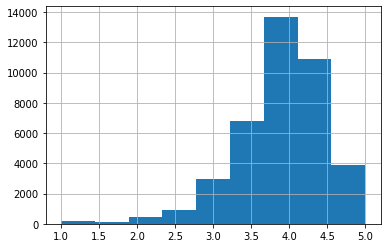

In [16]:
df.rating.hist(bins=9)

In [17]:
df.rating.describe()

count   40,000.00
mean         3.99
std          0.67
min          1.00
25%          3.50
50%          4.00
75%          4.50
max          5.00
Name: rating, dtype: float64

In [18]:
# Производим очистку данных от выбросов
#clear_sign_num('rating')

# Приступаем к очистке данных и созданию новых признаков

## Проверяем дублирование записей по базе данных TripAdvisor

In [19]:
# Смотрим, сколько записей в базе данных ресторанов TripAdvisor могут иметь дублирование
(df.id_ta.value_counts() > 1).sum()

20

####  Получилось 20 дублированных записей

In [20]:
# Смотрим идентификационные номера дублированных записей
df_vc = df.id_ta.value_counts().head(20)
df_vc

d11698990    2
d7337366     2
d11921719    2
d7342803     2
d13002276    2
d3161682     2
d7809594     2
d2477531     2
d793170      2
d9877640     2
d697406      2
d8753348     2
d4600226     2
d987900      2
d11999956    2
d11674463    2
d10047799    2
d9802625     2
d1315077     2
d3685055     2
Name: id_ta, dtype: int64

In [21]:
# Анализируем полученные результаты
for id in df_vc.index:
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,240.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26551,id_3240,Madrid,NaN,"3,242.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,227.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366
32814,id_1197,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,198.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,199.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,"2,331.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,361.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803
36275,id_2467,Madrid,"['Spanish', 'Mediterranean']","2,469.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,675.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276
26696,id_2485,Madrid,['American'],"2,487.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,577.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682
39847,id_3709,Madrid,"['Spanish', 'Bar']","3,711.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","3,969.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594
19388,id_4331,Madrid,"['American', 'Spanish', 'Asian']","4,333.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,813.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
24545,id_3805,Madrid,['Spanish'],"3,807.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,408.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170
36822,id_2487,Madrid,"['Italian', 'French', 'European']","2,489.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",476.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
15565,id_530,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",531.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,181.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
28096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,210.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,104.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],"1,213.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,112.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226
9446,id_4104,Madrid,['Spanish'],"4,106.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,363.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
22998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,314.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,538.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,664.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,806.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...","3,812.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,241.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
38946,id_3242,Madrid,NaN,"3,244.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,679.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
12938,id_2486,Madrid,NaN,"2,488.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",469.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077
25785,id_511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",512.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,649.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055
27680,id_5617,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,620.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


#### Видно, что все продублированные рестораны находятся в одном городе (Мадрид) и имеют практически абсолютно одинаковые параметры за исключением разного рейтинга внутри города ("ranking" - "rest_id", хотя, он очень близкий). Таким образом, у нас имеется 20 дублей, получившихся по непонятной причине

#### Поступаем следующим образом: городской рейтинг усредняем для каждой пары, после чего удаляем дублированные записи по признаку "id_ta"

In [22]:
# Замена значений городского рейтинга в дублированных записях на среднее значение пары
for id in df_vc.index:
    change_ranking(id)
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990
26551,id_3240,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366
32814,id_1197,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719
12628,id_2329,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803
36275,id_2467,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276
26696,id_2485,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682
39847,id_3709,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594
19388,id_4331,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531
24545,id_3805,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170
36822,id_2487,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640
15565,id_530,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406
28096,id_1209,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226
9446,id_4104,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900
22998,id_2312,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956
29879,id_3662,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463
11583,id_3810,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799
38946,id_3242,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625
12938,id_2486,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077
25785,id_511,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055
27680,id_5617,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


In [23]:
# Удаляем дубли
df.drop_duplicates(subset=['id_ta'], inplace=True)

In [24]:
# Проверяем
for id in df_vc.index:
    display(df[df.id_ta == id])

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
26431,id_3238,Madrid,NaN,"3,241.00",4.50,NaN,7.00,"[[], []]",/Restaurant_Review-g187514-d11698990-Reviews-V...,d11698990


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10183,id_1225,Madrid,"['Mediterranean', 'European', 'Spanish', 'Vege...","1,212.00",4.00,$$ - $$$,272.00,"[['Simply Excellent!', 'Modern!'], ['10/22/201...",/Restaurant_Review-g187514-d7337366-Reviews-La...,d7337366


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10819,id_2197,Madrid,NaN,"2,265.00",4.50,NaN,16.00,"[[], []]",/Restaurant_Review-g187514-d11921719-Reviews-C...,d11921719


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
22924,id_2359,Madrid,"['Spanish', 'Mediterranean']","2,415.00",4.50,$$ - $$$,16.00,"[['The real codido madrileño'], ['03/31/2017']]",/Restaurant_Review-g187514-d7342803-Reviews-Lo...,d7342803


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
1579,id_2673,Madrid,['American'],"2,581.00",5.00,$,6.00,"[['Healthy vegan doughnuts are posible', 'Best...",/Restaurant_Review-g187514-d13002276-Reviews-D...,d13002276


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
25251,id_3575,Madrid,"['Spanish', 'Bar']","3,644.00",3.50,$,217.00,"[['Thursday snack', 'Good value for money & go...",/Restaurant_Review-g187514-d3161682-Reviews-Ce...,d3161682


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15525,id_3967,Madrid,"['American', 'Spanish', 'Asian']","4,151.00",3.50,NaN,61.00,"[[], []]",/Restaurant_Review-g187514-d7809594-Reviews-La...,d7809594


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8421,id_3811,Madrid,['Spanish'],"3,810.00",4.00,$,23.00,"[['Happened to drop in', 'Right for a quick bi...",/Restaurant_Review-g187514-d2477531-Reviews-Ha...,d2477531


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
5240,id_2406,Madrid,"['Italian', 'French', 'European']","2,448.00",4.00,$$ - $$$,148.00,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",/Restaurant_Review-g187514-d793170-Reviews-Car...,d793170


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
15295,id_475,Madrid,"['Japanese', 'Vegetarian Friendly', 'Vegan Opt...",504.00,4.50,$$ - $$$,67.00,"[['Whenever in Madrid, we never miss this gem....",/Restaurant_Review-g187514-d9877640-Reviews-Ra...,d9877640


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4578,id_1180,Madrid,"['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...","1,196.00",4.00,$$ - $$$,341.00,"[['Great food, service and atmosphere', 'Decor...",/Restaurant_Review-g187514-d697406-Reviews-Al_...,d697406


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],"1,158.00",4.50,$$ - $$$,73.00,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
147,id_4110,Madrid,['Spanish'],"4,109.00",5.00,NaN,2.00,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
8019,id_2361,Madrid,"['Seafood', 'Mediterranean', 'European', 'Span...","2,338.00",4.00,$$ - $$$,190.00,"[['Nice restaurant in Madrid', 'Highly reccome...",/Restaurant_Review-g187514-d987900-Reviews-Com...,d987900


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
16920,id_3536,Madrid,"['International', 'Mediterranean', 'Spanish', ...","3,601.00",4.00,$$ - $$$,52.00,"[['Great Food! Wide Variety.', 'Dinner'], ['11...",/Restaurant_Review-g187514-d11999956-Reviews-S...,d11999956


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
4732,id_3804,Madrid,"['American', 'German', 'European', 'Central Eu...","3,809.00",4.00,NaN,8.00,"[[], []]",/Restaurant_Review-g187514-d11674463-Reviews-B...,d11674463


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
13980,id_3239,Madrid,NaN,"3,242.00",5.00,NaN,13.00,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10594,id_2677,Madrid,NaN,"2,584.00",5.00,NaN,10.00,"[['Absolutely authentic and delicious!', 'Wond...",/Restaurant_Review-g187514-d9802625-Reviews-La...,d9802625


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
10439,id_468,Madrid,"['Mediterranean', 'Spanish', 'Vegetarian Frien...",490.00,4.00,$$ - $$$,355.00,"[['Very good all around', 'Our first Madrid re...",/Restaurant_Review-g187514-d1315077-Reviews-El...,d1315077


,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta
3942,id_5646,Madrid,"['Lebanese', 'Mediterranean', 'Middle Eastern'...","5,634.00",3.50,$$ - $$$,443.00,"[['Good Lebanese food', 'Decent place'], ['07/...",/Restaurant_Review-g187514-d3685055-Reviews-Sh...,d3685055


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   restaurant_id  39980 non-null  object 
 1   city           39980 non-null  object 
 2   cuisine_style  30701 non-null  object 
 3   ranking        39980 non-null  float64
 4   rating         39980 non-null  float64
 5   price_range    26101 non-null  object 
 6   reviews_count  37437 non-null  float64
 7   reviews        39980 non-null  object 
 8   url_ta         39980 non-null  object 
 9   id_ta          39980 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.4+ MB


### Дублей больше нет. Количество записей, таким образом, уменьшилось на 20

## Работа с признаком "price_range" (ценовой диапазон)

In [26]:
# Смотрим уникальные значения ценового диапазона
df.price_range.unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [27]:
# Отсутствующее значения ценового диапазона ресторана заполним средними значениями
df.price_range.fillna('$$ - $$$', inplace = True)

In [28]:
# "Оцифровываем" признак: '$' - 1, '$$ - $$$' - 2, '$$$$' - 3
df.price_range = df.price_range.apply(lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3)

#### Проверяем, что получилось

In [29]:
df.price_range.unique()

array([2, 3, 1], dtype=int64)

In [30]:
df.price_range.value_counts()

2    32281
1     6276
3     1423
Name: price_range, dtype: int64

## Работа с признаком "reviews_count" (количество отзывов)

In [31]:
df.reviews_count.describe()

count   37,437.00
mean       124.83
std        295.73
min          2.00
25%          9.00
50%         33.00
75%        115.00
max      9,660.00
Name: reviews_count, dtype: float64

In [32]:
# Заполняем отсутствующие значения количества отзывов нулями
df.reviews_count.fillna(0, inplace = True)
#df.reviews_count.fillna(df.reviews_count.min(), inplace = True)

In [33]:
# Проверяем
df.reviews_count.isna().sum()

0

## Работа с признаком  "reviews" (отзывы)

In [34]:
# Создаем новый столбец с признаком наличия (1) или отсутствия (0) отзывов
df['reviews_sign'] = df.reviews.apply(lambda x: 0 if len(x) < 10 else 1)

# Смотрим, что получилось
df['reviews_sign'].value_counts()

1    33515
0     6465
Name: reviews_sign, dtype: int64

In [35]:
# Создаем временный столбец с датами последних отзывов и заполняем его (пустые значения делаем nan)
df['last_date_rev'] = df.reviews.apply(last_date_review)

In [36]:
# Определяем дату самого последнего отзыва
max_date = df['last_date_rev'].max()

In [37]:
# Создаем новый столбец (признак) с интервалом дат между отзывами и заполняем его
df['delta_date_rev'] = df[df.last_date_rev.notnull()].last_date_rev.apply(lambda x: (max_date - x).days)

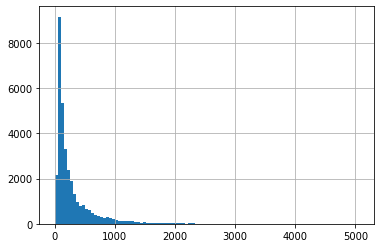

In [38]:
# График распределения нового признака delta_date_rev
df['delta_date_rev'].hist(bins = 100)

In [39]:
# Заполняем пропуски средними значениями
df['delta_date_rev'].fillna(df.delta_date_rev.mean(), inplace = True)

In [40]:
# Удаляем временный столбец с с датами последних отзывов
df.drop('last_date_rev', axis = 1, inplace = True)

In [41]:
# Производим очистку данных от выбросов
clear_sign_num('delta_date_rev')

## Работаем с признаком  "cuisine_style" (стили кухни)

#### Блок определения медианного количества стилей кухни в ресторанах и их наименований

In [42]:
# Количество пропущенных значений
df.cuisine_style.isna().sum()

7845

In [43]:
# В пропущенные значения заносим "Cafe"
df['cuisine_style'].fillna("['Cafe']", inplace = True)

In [44]:
# Замена в датафрейме строковой переменной стиля кухни на список
df['cuisine_style'] = df['cuisine_style'].apply(cuisine_to_list)

In [45]:
# Составляем список уникальных значений стилей кухни
cuisin_list = set()  # создаём пустое множество для хранения уникальных значений стилей кухни

for item in df['cuisine_style']:  # перебор всех ресторанов    
    for cuis in item:  # перебор стилей кухни
        cuisin_list.add(cuis)  # заполняем список уникальных значений

In [46]:
# Проверяем
df.cuisine_style.isna().sum()

0

#### Делаем "оцифровку" стилей кухни

In [47]:
# Создаем столбцы для каждого стиля кухни
for item in cuisin_list:
    df[item] = df['cuisine_style'].apply(lambda x: 1 if item in x else 0)

In [48]:
# Меняем значения столбца: вместо списка записываем количество предлагаемых рестораном стилей кухни
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: len(x))

In [49]:
# Смотрим, сколько вариантов различной кухни предлагают рестораны
df['cuisine_style'].value_counts()

1     13572
2      5457
3      4984
4      4639
5      3547
6      2025
7      1016
8       282
9        74
10       19
11        3
21        1
13        1
Name: cuisine_style, dtype: int64

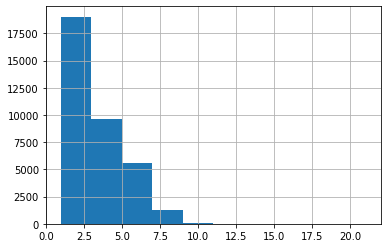

In [50]:
# График распределения
df['cuisine_style'].hist()

In [51]:
# Производим очистку данных от выбросов
clear_sign_num('cuisine_style')

In [52]:
# Проверяем
df['cuisine_style'].value_counts()

1    13572
2     5457
3     4984
4     4639
5     3547
6     2025
7     1016
8      282
Name: cuisine_style, dtype: int64

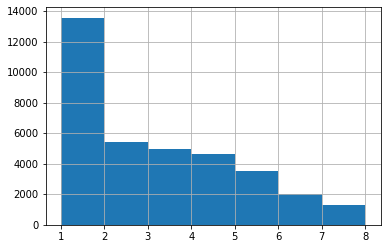

In [53]:
# График распределения
df['cuisine_style'].hist(bins = 7)

## Работа с  признаком "city" (города)

In [54]:
# Смотрим, сколько уникальных названий городов
df.city.nunique()

31

In [55]:
# Количество ресторанов в каждом из городов
df.city.value_counts()

London        5290
Paris         4239
Madrid        2737
Barcelona     2434
Rome          1868
Milan         1867
Berlin        1841
Prague        1251
Lisbon        1151
Vienna        1048
Amsterdam     1014
Brussels       943
Hamburg        823
Munich         800
Lyon           775
Budapest       730
Stockholm      693
Dublin         634
Warsaw         627
Copenhagen     599
Edinburgh      561
Athens         543
Zurich         489
Oporto         475
Geneva         411
Krakow         392
Oslo           346
Helsinki       336
Bratislava     256
Luxembourg     191
Ljubljana      158
Name: city, dtype: int64

#### Города не повторяются в различном написании, очистка не требуется

### Анализ признака "city"

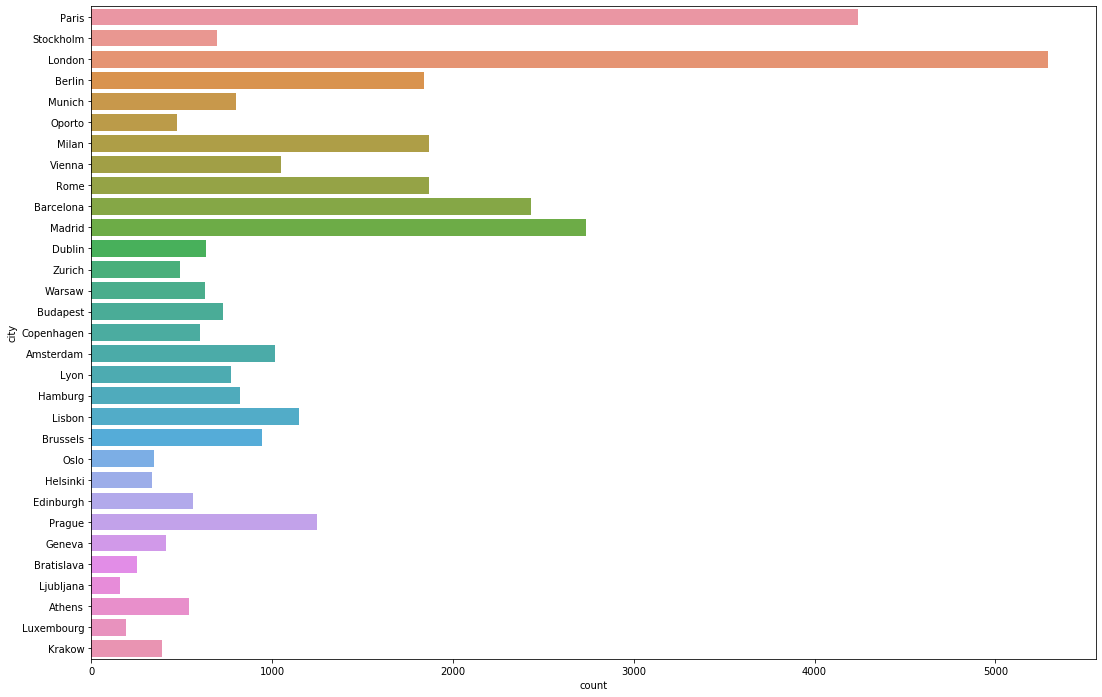

In [56]:
# График распределния ресторанов по городам
fig, ax = plt.subplots(figsize=(18, 12))
sns.countplot(y = 'city', data = df, ax=ax)

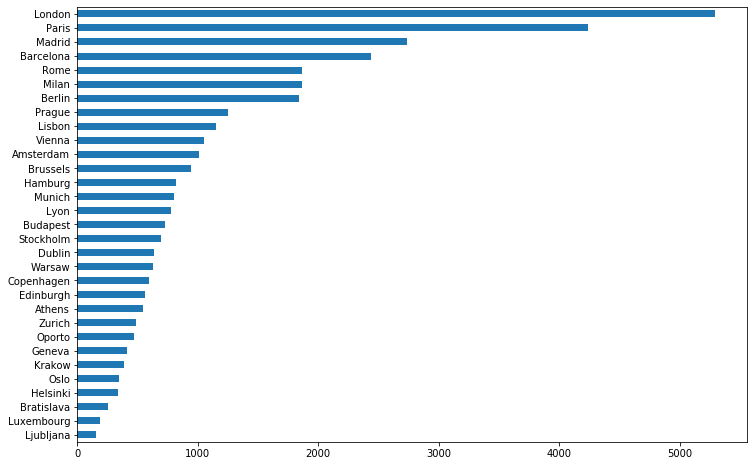

In [57]:
# График распределния ресторанов по городам
fig, ax = plt.subplots(figsize=(12, 8))
df['city'].value_counts(ascending = True).plot(kind = 'barh')

#### Проверяем города на наличие выбросов

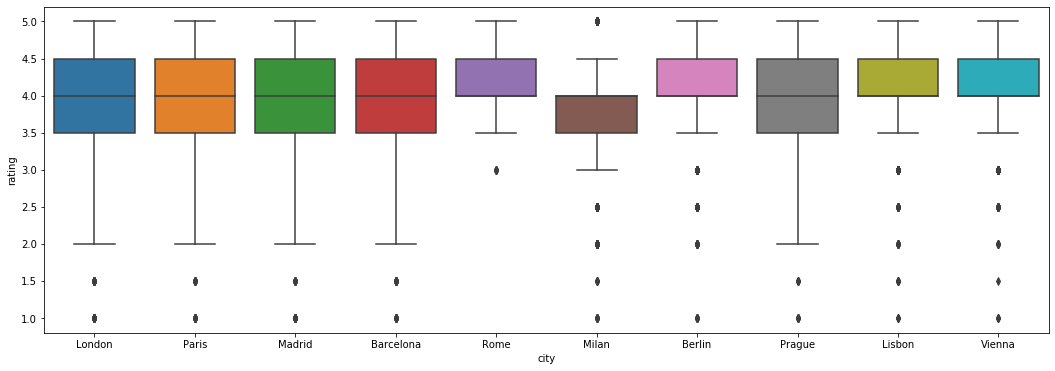

In [58]:
# Построим графики box-plot для первых десяти городов из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[0:10].index, ax=ax)
plt.show()

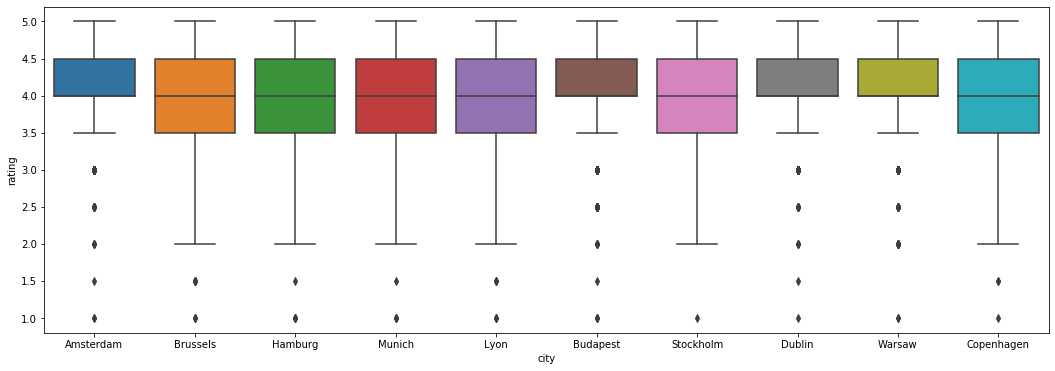

In [59]:
# Построим графики box-plot для следующих десяти городов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[10:20].index, ax=ax)
plt.show()

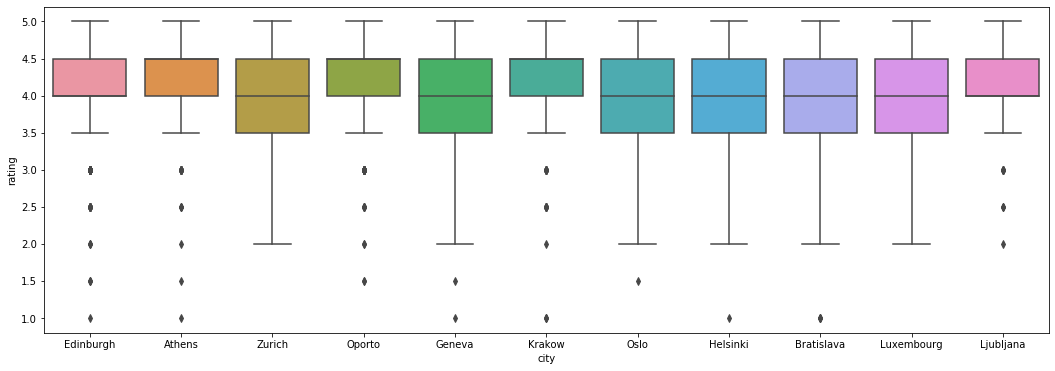

In [60]:
# Построим графики box-plot для оставшихся городов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='city', y='rating', data=df, order=(df['city'].value_counts())[20:].index, ax=ax)
plt.show()

#### Имеются отдельные выбросы

In [61]:
# Производим очистку данных от выбросов
clear_sign('city')

#### Проверяем результат

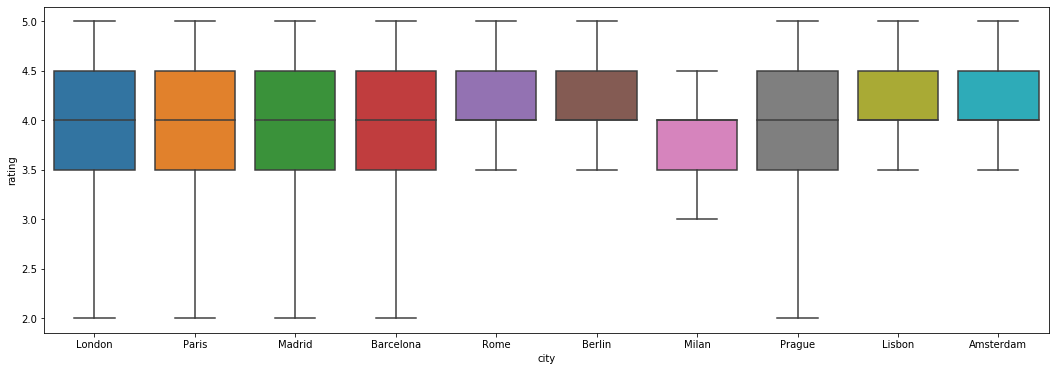

In [62]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[0:10].index, ax=ax)
plt.show()

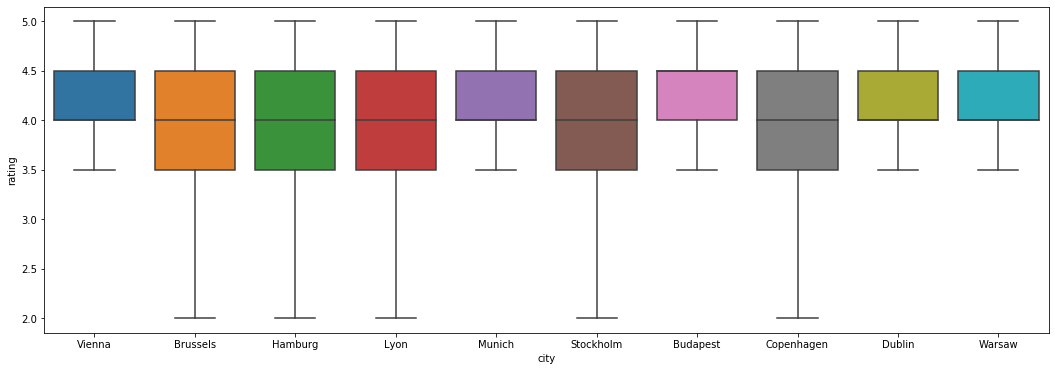

In [63]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[10:20].index, ax=ax)
plt.show()

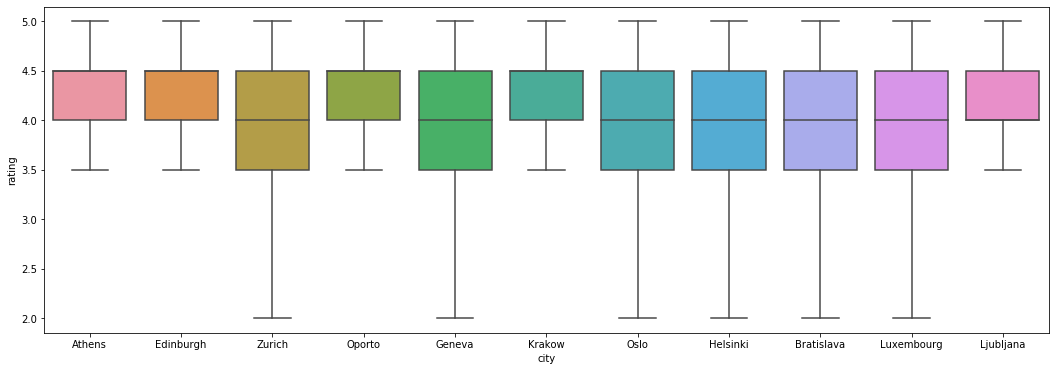

In [64]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="city", y="rating", data=df, order=(df['city'].value_counts())[20:].index, ax=ax)
plt.show()

#### Результат достигнут: выбросов больше нет

### Введём несколько дополнительных признаков. Для работы будем использовать базу данных с городами, столицами и регионами Европы, которая была взята с GitHub и доработана под текущие задачи

In [65]:
# Загружаем базу данных с городами, столицами и регионами Европы
df_cities = pd.DataFrame(europe_countries_info.countries)

#### Вводим новый признак: "capital" - является ли город столицей государства (1 - да, 0 - нет)

In [66]:
df['capital'] = df.city.apply(lambda x: 1 if x in list(df_cities['capital']) else 0)

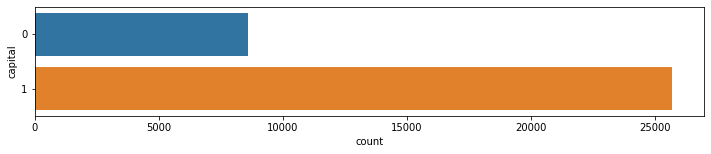

In [67]:
# График, показывающий распределение столичных и нестоличных ресторанов
fig, ax = plt.subplots(figsize=(12, 2))
sns.countplot(y = 'capital', data = df, ax=ax)

#### Вводим ещё один новый признак: "country" - в какой стране находится город

In [68]:
df['country'] = df.city.apply(find_country)

In [69]:
# Смотрим, в каких странах находятся рестораны из базы данных
df['country'].value_counts()

United Kingdom                5744
Spain                         5085
France                        4971
Italy                         3516
Germany                       3257
Portugal                      1475
Czech Republic                1237
Kingdom of the Netherlands     950
Austria                        948
Poland                         938
Belgium                        933
Switzerland                    898
Sweden                         692
Hungary                        657
Denmark                        596
Republic of Ireland            574
Greece                         521
Norway                         345
Finland                        335
Slovakia                       252
Luxembourg                     191
Slovenia                       147
Name: country, dtype: int64

In [70]:
# Сколько стран
df['country'].nunique()

22

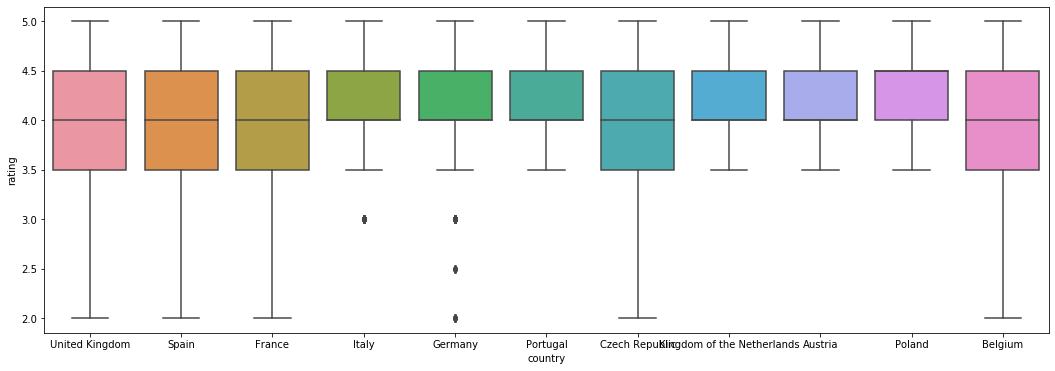

In [71]:
# Построим графики box-plot для первых одиннадцати стран из списка
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[0:11].index, ax=ax)
plt.show()

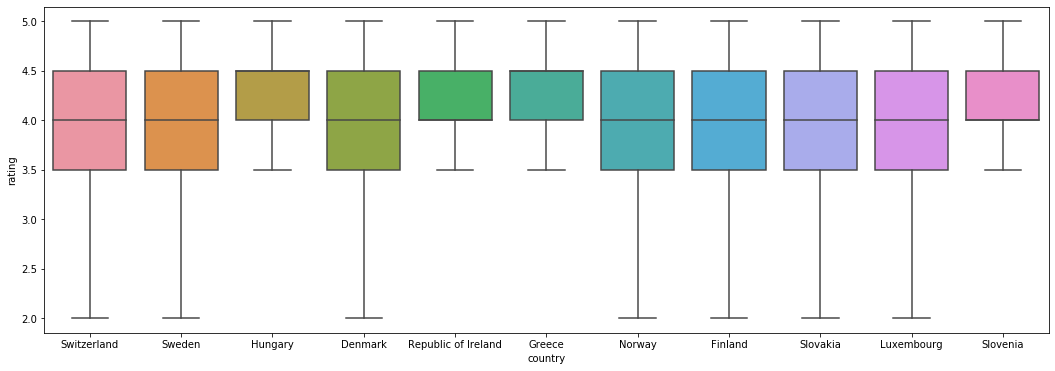

In [72]:
# Построим графики box-plot для оставшихся стран
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[11:].index, ax=ax)
plt.show()

#### Выбросов по странам практически нет

In [73]:
# Производим очистку данных от выбросов
clear_sign('country')

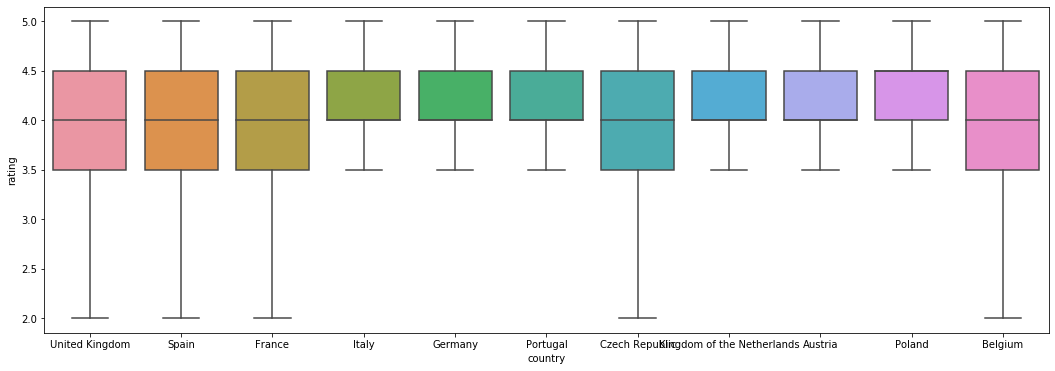

In [74]:
# Выборочно проверяем...
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="country", y="rating", data=df, order=(df['country'].value_counts())[0:11].index, ax=ax)
plt.show()

#### Вводим новый признак: "region" - Западная, Восточная, Южная или Северная Европа

In [75]:
df['region'] = df.city.apply(find_region)

In [76]:
# Проверяем
df['region'].value_counts()

West     12070
South    10571
North     8286
East      3084
Name: region, dtype: int64

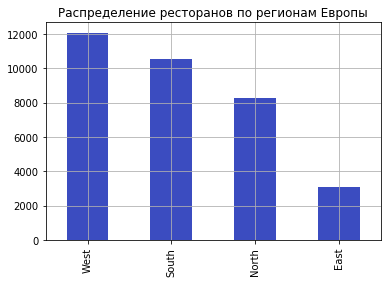

In [77]:
# Смотрим распределение ресторанов по регионам Европы
df['region'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Распределение ресторанов по регионам Европы')

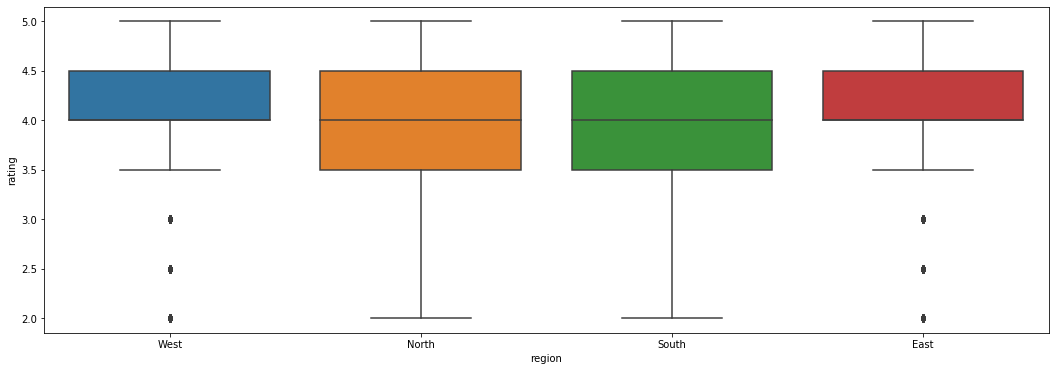

In [78]:
# Построим графики box-plot для регионов
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="region", y="rating", data=df, ax=ax)
plt.show()

In [79]:
# Производим очистку данных от выбросов
clear_sign('region')

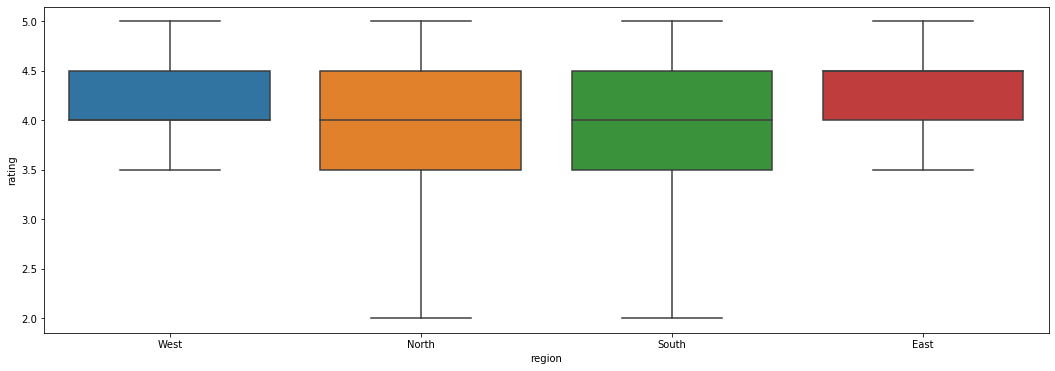

In [80]:
# Проверяем
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x="region", y="rating", data=df, ax=ax)
plt.show()

## Работа с признаком "ranking" (место, которое занимает данный ресторан среди всех ресторанов своего города)

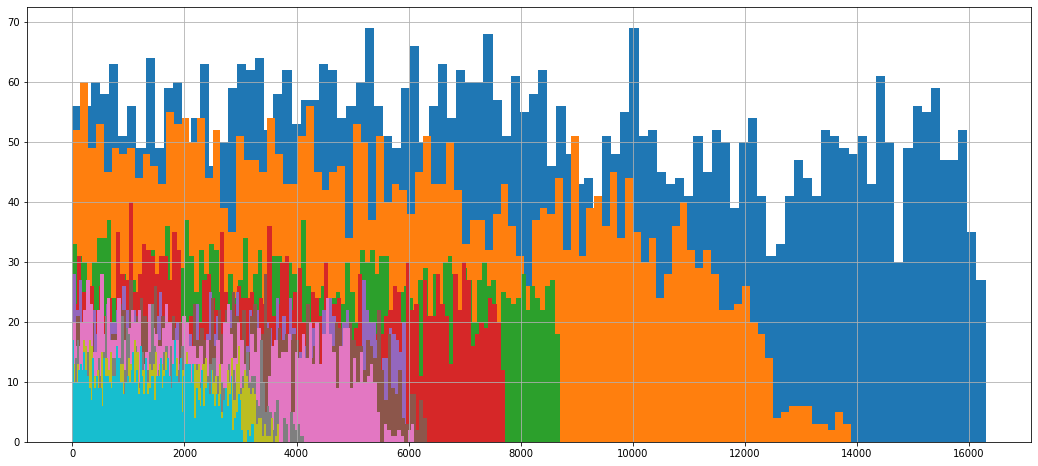

In [81]:
# Выведем графики распределения городского рейтинга для первой десятки городов
fig, ax = plt.subplots(figsize=(18, 8))
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins = 100)
plt.show()

#### В городах разное количество ресторанов и, соответственно, разное максимальное значение городского рейтинга (места в городе). Сформируем новый признак, содержащий максимальное значение городского рейтинга

In [82]:
# Создание словаря с максимальным значением рейтинга по городам
rank_max_city = {}
for city in (df['city'].value_counts()).index:
    rank_max_city[city] = df[df['city'] == city]['ranking'].max()

In [83]:
# Создание нового признака - максимального значения городского рейтинга в данном городе
df['rank_max'] = df.apply(lambda x: rank_max_city[x['city']], axis = 1)

### Производим "оцифровку" данных

In [84]:
# "Оцифровываем" города
df = pd.get_dummies(df, columns=['city'])

In [85]:
# "Оцифровываем" страны
df = pd.get_dummies(df, columns=['country'])

In [86]:
# "Оцифровываем" регионы
df = pd.get_dummies(df, columns=['region'])

#### Созданим ещё два новых признака, выделив целочисленную часть из признаков "restaurant_id" и "id_ta", хотя использование признака "id_ta" может быть не совсем корректно, так как это всё-таки конечный результат оценочной деятельности компании

In [87]:
df['id_trip'] = df.id_ta.apply(lambda x: int(x[1:]))
df['id_rest'] = df.restaurant_id.apply(lambda x: int(x[3:]))

In [88]:
# Смотрим результат
df.head()

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_count,reviews,url_ta,id_ta,reviews_sign,delta_date_rev,Egyptian,Xinjiang,Latin,Pizza,Gastropub,Swiss,Balti,Asian,Malaysian,Taiwanese,Albanian,Mediterranean,Persian,International,Gluten Free Options,Pub,Korean,Israeli,Norwegian,Contemporary,Nepali,Delicatessen,Portuguese,Jamaican,Colombian,Uzbek,Native American,Polynesian,Ukrainian,Venezuelan,Grill,Afghani,Cambodian,Mongolian,Caucasian,Austrian,Australian,Singaporean,Ecuadorean,Argentinean,Central American,Burmese,Azerbaijani,Georgian,Brew Pub,Vietnamese,Caribbean,Sri Lankan,Filipino,Moroccan,Vegetarian Friendly,Sushi,Irish,Seafood,Ethiopian,Steakhouse,Turkish,Peruvian,American,Slovenian,African,Tunisian,Wine Bar,Cajun & Creole,Scandinavian,Fast Food,French,Welsh,Danish,Russian,South American,Latvian,Belgian,Diner,Kosher,Canadian,Tibetan,Greek,Polish,Italian,Central Asian,Cuban,Halal,Chilean,Healthy,Thai,Chinese,Fusion,Czech,Bangladeshi,Bar,German,Eastern European,Croatian,Japanese,Fujian,Salvadoran,Central European,Romanian,Hungarian,Yunnan,Soups,Middle Eastern,New Zealand,Indian,Swedish,Lebanese,European,Pakistani,Minority Chinese,Scottish,Spanish,Brazilian,Vegan Options,Arabic,Hawaiian,Armenian,Mexican,British,Southwestern,Street Food,Cafe,Barbecue,Dutch,Indonesian,capital,rank_max,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,country_Austria,country_Belgium,country_Czech Republic,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Italy,country_Kingdom of the Netherlands,country_Luxembourg,country_Norway,country_Poland,country_Portugal,country_Republic of Ireland,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_United Kingdom,region_East,region_North,region_South,region_West,id_trip,id_rest
0,id_5569,3,"5,570.00",3.50,2,194.00,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,1,57.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"13,894.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1912643,5569
1,id_1535,1,"1,537.00",4.00,2,10.00,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,235.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,"2,439.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,7992032,1535
2,id_352,7,353.00,4.50,3,688.00,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,1,49.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,"16,297.00",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,8632781,352
3,id_3456,1,"3,458.00",5.00,2,3.00,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,0,289.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Проверка получившейся модели

In [89]:
# Проверяем, чтобы наша целевая переменная после очистки данных сильно не деградировала
df['rating'].value_counts()

4.00    12285
4.50     9873
3.50     5989
5.00     3348
3.00     1049
2.50      329
2.00      153
Name: rating, dtype: int64

In [90]:
# Корреляция между основными признаками
df[['ranking', 'id_rest', 'id_trip', 'rank_max', 'reviews_sign', 'cuisine_style', 'price_range', 'reviews_count', 
    'delta_date_rev', 'capital', 'rating']].corr()

,ranking,id_rest,id_trip,rank_max,reviews_sign,cuisine_style,price_range,reviews_count,delta_date_rev,capital,rating
ranking,1.00,1.00,0.09,0.69,-0.13,-0.32,-0.05,-0.23,0.20,0.22,-0.36
id_rest,1.00,1.00,0.09,0.69,-0.13,-0.32,-0.05,-0.23,0.20,0.22,-0.36
id_trip,0.09,0.09,1.00,-0.06,-0.24,-0.27,-0.06,-0.32,0.10,0.00,0.23
rank_max,0.69,0.69,-0.06,1.00,0.07,-0.03,0.00,0.03,-0.06,0.32,-0.11
reviews_sign,-0.13,-0.13,-0.24,0.07,1.00,0.33,-0.08,0.18,-0.33,0.09,-0.06
cuisine_style,-0.32,-0.32,-0.27,-0.03,0.33,1.00,0.02,0.39,-0.43,0.01,0.05
price_range,-0.05,-0.05,-0.06,0.00,-0.08,0.02,1.00,0.12,-0.02,-0.01,-0.02
reviews_count,-0.23,-0.23,-0.32,0.03,0.18,0.39,0.12,1.00,-0.29,-0.00,-0.02
delta_date_rev,0.20,0.20,0.10,-0.06,-0.33,-0.43,-0.02,-0.29,1.00,-0.06,-0.02
capital,0.22,0.22,0.00,0.32,0.09,0.01,-0.01,-0.00,-0.06,1.00,-0.01


#### Из коореляционной матрицы видна 100% зависимость между  признаками: "id_rest" и "ranking". Поэтому признак "ranking" исключим из состава данных для обучения модели

In [91]:
# Готовим входные данные для проверки модели:

# 1. Исходные данные модели: очищенный датасет без номинативных признаков, целевой переменной и признака "ranking"
data_test_1 = df.drop(['rating', 'restaurant_id', 'reviews', 'url_ta', 'id_ta', 'ranking'], axis = 1)

# 2. Целевая переменная - "rating"
target = df['rating']

MAE: 0.18884703887610513


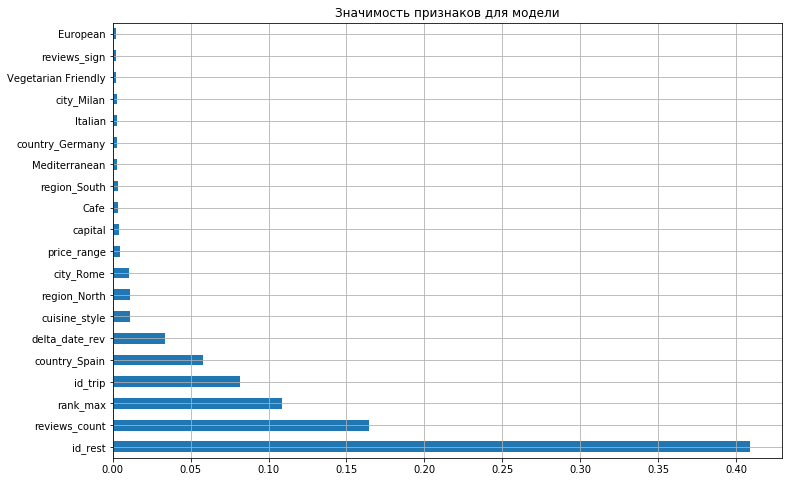

In [92]:
print('MAE:', estimate_MAE(data_test_1, target))

#### Признак "id_trip" несколько ухудшает значение параметра МАЕ, поэтому тоже исключим его из состава признаков для обучения модели

In [96]:
# Готовим входные данные для проверки модели:

# 1. Исходные данные модели: очищенный датасет без номинативных признаков, целевой переменной и признаков "ranking" и "id_trip"
data_test_2 = df.drop(['rating', 'restaurant_id', 'reviews', 'url_ta', 'id_ta', 'ranking', 'id_trip'], axis = 1)

# 2. Целевая переменная - "rating"
target = df['rating']

MAE: 0.18631100884098342


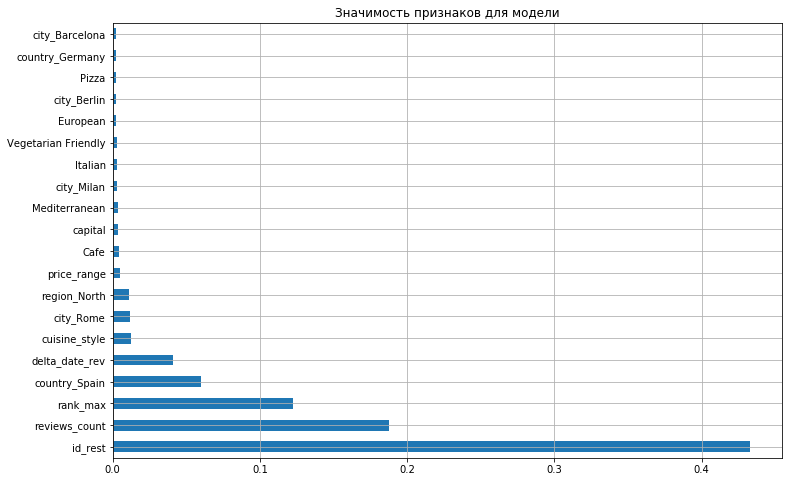

In [97]:
print('MAE:', estimate_MAE(data_test_2, target))

### Таким образом, именно этот набор данных ("data_test_2") целесообразно использовать в дальнейшем для обучения модели

In [95]:
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33026 entries, 0 to 39998
Columns: 190 entries, cuisine_style to id_rest
dtypes: float64(3), int64(130), uint8(57)
memory usage: 36.8 MB
